## Packages

In [1]:
import numpy as np
import os
import pandas as pd
import time
from pathlib import Path
from datetime import datetime
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
import torchvision
import torchvision.models
import torchvision.transforms as transforms
from torch.optim import SGD, Adam, AdamW
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import DatasetFolder, ImageFolder
from tqdm import tqdm
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, \
accuracy_score
from avalanche.models import SlimResNet18, MTSlimResNet18, SimpleCNN
from avalanche.models import as_multitask, IncrementalClassifier
from avalanche.models.utils import avalanche_model_adaptation
from avalanche.training import Naive, LwF, GenerativeReplay, ICaRLLossPlugin, ICaRL, EWC, AR1, LFL, AGEM
from avalanche.logging import (
    InteractiveLogger,
    TextLogger,
    CSVLogger,
)
from avalanche.training.plugins import EvaluationPlugin, ReplayPlugin, LwFPlugin, EarlyStoppingPlugin, AGEMPlugin
from avalanche.training.plugins.lr_scheduling import LRSchedulerPlugin
from avalanche.benchmarks import nc_benchmark, ni_benchmark
from avalanche.benchmarks.utils import AvalancheDataset
from avalanche.benchmarks.scenarios.dataset_scenario import benchmark_from_datasets
from avalanche.benchmarks.scenarios.supervised import class_incremental_benchmark
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics,loss_metrics, \
timing_metrics, cpu_usage_metrics, StreamConfusionMatrix, disk_usage_metrics, gpu_usage_metrics, \
confusion_matrix_metrics, bwt_metrics, forward_transfer_metrics, ram_usage_metrics, images_samples_metrics
from avalanche.evaluation.metrics import Accuracy, BWT, Forgetting, ForwardTransfer
import multiprocessing as mp
import my_utils
import my_architectures
import my_dataloaders
# import my_gwpy_and_fractals
import my_transformations
IMG_SIZE = (224,224)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D:\Users\Brian\MscThesis_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# calculating the amount of workers usable
number_of_workers = mp.cpu_count()
number_of_workers = int(number_of_workers/2)
print(number_of_workers)

6


In [3]:
# Setting the correct directories
train_dir = 'D:\\Users\\Brian\\TrainingSet_CL_1\\TrainingSet_CL_1'
#train_dir = 'C:\\Users\\Brian.Baert\\TrainingSet_CL_1'
train_dir_2 = 'D:\\Users\Brian\\TrainingSet_CL_2\\TrainingSet_CL_2'
#train_dir_2 = 'C:\\Users\\Brian.Baert\\TrainingSet_CL_2'
val_dir = 'D:\\Users\\Brian\\TestSet_CL\\TestSet_CL'
#val_dir = 'C:\\Users\\Brian.Baert\\ValidationSet_CL'
test_dir = 'D:\\Users\\Brian\\TestSet_CL\\TestSet_CL'
#test_dir = 'C:\\Users\\Brian.Baert\\TestSet_CL'

# Read in class labels
class_file = open("classes.txt", "r")
classes = class_file.read()
classes = classes.split(", ")

## MultiView Fusion Naive model

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = my_architectures.BaselineColorNet_resnet18(num_classes=10)
model.to(device)
# log to text file
text_logger = TextLogger(open("multiview_fusion_naive_log.txt", "a"))
# print to stdout
interactive_logger = InteractiveLogger()
csv_logger = CSVLogger()
classes = my_utils.get_classes_from_dir(train_dir_2)
class_to_indx = my_utils.classes_to_indices(classes)

In [5]:
print(classes)

['Blip', 'Blip_Low_Frequency', 'Extremely_Loud', 'Fast_Scattering', 'Koi_Fish', 'Low_Frequency_Burst', 'Low_Frequency_Lines', 'Scattered_Light', 'Tomte', 'Whistle']


In [6]:
train_set = my_dataloaders.MultiViewGravitySpyDataset(root=train_dir, cls=classes, transform=my_transformations.transformAV_Fuse_Crop)
val_set = my_dataloaders.MultiViewGravitySpyDataset(root=val_dir, cls=classes, transform=my_transformations.transformAV_Fuse)
test_set = my_dataloaders.MultiViewGravitySpyDataset(root=test_dir, cls=classes, transform=my_transformations.transformAV_Fuse)

train_set_av = AvalancheDataset(train_set)
train_loader_av = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=number_of_workers)

val_set_av = AvalancheDataset(val_set)
val_loader_av = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True, num_workers=number_of_workers)

test_set_av = AvalancheDataset(test_set)
test_loader_av = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

train_set_av.targets = [label for i, label in enumerate(train_set.labels) if i % 4 == 0]
test_set_av.targets = [label for i, label in enumerate(test_set.labels) if i % 4 == 0]
val_set_av.targets = [label for i, label in enumerate(val_set.labels) if i % 4 == 0]

train_set_av.uniques = list(set(train_set.labels))
test_set_av.uniques = list(set(test_set.labels))
val_set_av.uniques = list(set(val_set.labels))

In [7]:
# Get the first batch from the dataloader
batch = next(iter(train_set))

# Extract the first image and its label (if available)
image, label = batch

In [8]:
image.shape

torch.Size([3, 224, 224])

In [9]:
label

0

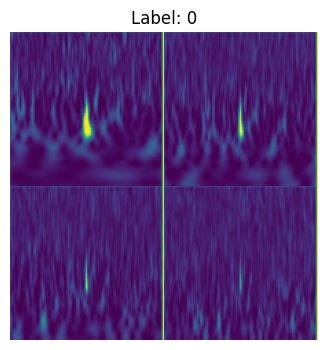

In [10]:
# Convert image tensor to numpy array
image_np = image[1].numpy()
# Create a subplot and display the image
plt.figure(figsize=(4, 4))
plt.imshow(image_np)
#plt.imshow(image_np.transpose(1, 2, 0))  # Transpose to (H, W, C) format
plt.axis('off')  # Hide axes
plt.title(f"Label: {label}") if label is not None else plt.title("First Image")
plt.show()

In [11]:
bm = nc_benchmark(
    train_dataset=train_set_av,
    test_dataset=val_set_av,
    n_experiences=5,
    shuffle=True,
    seed=1234,
    task_labels=False,
    class_ids_from_zero_in_each_exp=False,
)

In [12]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=False, stream=True),
    ram_usage_metrics(experience=True, stream=True, epoch=False),
    bwt_metrics(experience=True, stream=True),
    loggers=[interactive_logger, text_logger, csv_logger],
    strict_checks=False,
)

In [13]:
# OPTIMIZER and CRITERION
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = CrossEntropyLoss()
#criterion = CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32), label_smoothing=0.2)

In [14]:
# NAIVE STRATEGY
cl_strategy = Naive(
    model=model, optimizer=optimizer, criterion=criterion, train_mb_size=32, train_epochs=20, 
    eval_mb_size=16, device=device, evaluator=eval_plugin, 
    plugins=[ReplayPlugin(mem_size=2*len(train_set)), EarlyStoppingPlugin(patience=2, val_stream_name='train')]
)

In [ ]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'naive_fusion')

Starting experiment with strategy: <avalanche.training.supervised.strategy_wrappers.Naive object at 0x00000283FF02B6D0>
Start of experience:  0
Current Classes:  [4, 5]
-- >> Start of training phase << --
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:17<00:00,  5.98s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.2970
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8150
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:20<00:00,  1.55s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2134
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:20<00:00,  1.54s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0214
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|█████████████████████████████████████████████████

In [ ]:
# SAVE MODEL
my_utils.checkpoint(model, 'Models/thesis_MultiView_Naive_CL.pth')

In [ ]:
# SOME TEST PREDICTIONS
my_utils.n_test_predictions(model, test_loader_av, classes, 20)

In [ ]:
# CALCULATE ALL PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)

In [ ]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

In [ ]:
# PLOT CM
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_MultiView_Naive.png')

In [ ]:
# PLOT F1
my_utils.plot_f1_scores(f1, classes, 'Results/f1_scores_MultiView_Naive.png')

In [ ]:
my_utils.plot_tSNE_data_embedding(model, train_loader_av, classes, 'Results/tSNE_MultiView_Naive.png')